In [1]:
#!/usr/bin/env python
"""Detect outlier from neurokit data

We'd like to detect spikes in the data that is not a signal
* Here, we first preprocess the data via `filter_physio`. This detrends and downsamples the data to the TR time.
* Then, the main point of this function is to identify residual outliers using the `seasonal_decompose` function from statsmodels.tsa.seasonal
* Once the residuals are identified, I use a Zscore of 2 to identify the erroneous datapoints.
* This is returned as an index.
* We save the outlier indices and the plots for inspection.

We plot the outliers, overlaying it on top of the (1) raw data, (2) first derivative, (3) second derivative
"""
# NOTE: from Green, Kragel, etc
# The rises of candidate SCRs were found by searching for sections of the first order temporal derivative of the skin conductance data, S′,
# that are above the threshold of U μS per second for a minimum duration of w seconds (Fig. 1A).2
# 1) calculate first order derivatives

# Candidate SCRs were classified as being isolated or affected by neighboring responses by searching for patterns of inflection points (zero crossings in the second order temporal derivative). Inflection points were categorized based on whether the slope goes from increasing to decreasing (type A) or decreasing to increasing (type B) around the point. If there were three sequential inflection points within a SCR with a pattern A–B–A, then the center point B was used to split the SCR into multiple candidate responses (Fig. 1B).

# following response criteria were established as default: the latency between the eliciting stimulus onset and the rise of the response, or SCR latency, must be between 1 and 4 s; the time between response start and peak, or SCR duration, must occur between 0.5 and 5 s; and the response amplitude must be greater than 0.02 μS.

__author__ = "Heejung Jung"
__copyright__ = "Spatial Topology Project"
__credits__ = ["Heejung"] # people who reported bug fixes, made suggestions, etc. but did not actually write the code.
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = "Heejung Jung"
__email__ = "heejung.jung@colorado.edu"
__status__ = "Development"
# %%
import argparse
import glob
import json
import os
from pathlib import Path

# import matplotlib.dates as mdates
from importlib_resources import read_text
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np

import pandas as pd
import scipy
from scipy import signal
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from spacetop_prep.physio import utils
from spacetop_prep.physio.utils import initialize, preprocess


In [15]:

def filter_physio(physio, samplingrate = 2000, imagesize = 872, TR = .46 ):
    """AI is creating summary for filter_physio

    Args:
        physio (pd.Dataframe): Dataframe with unfiltered physiological data
        samplingrate (int, optional): Sampling rate of physiological signal. Defaults to 2000.
        imagesize (int, optional): Total number of images in brain/nifti file. Defaults to 872.
        TR (float, optional): TR length. Defaults to .46.

    Returns:
        [type]: [description]
    """
    scr_signal = nk.signal_sanitize(physio['physio_eda'])
    scr_filters = nk.signal_filter(scr_signal,
                                sampling_rate=samplingrate,
                                highcut=1,
                                method="butterworth",
                                order=2)  # ISABEL: Detrend
    scr_detrend = nk.signal_detrend(scr_filters)
    physio['eda_preproc'] = scr_detrend
    #  physio: down sample method 1
    x = np.arange(0,imagesize,1)

    fmri_rate = 1/TR
    number_of_samples = round(len(physio) * float(fmri_rate) / samplingrate)
    resampled_data = signal.resample(physio["eda_preproc"], number_of_samples)
    resampled_ttl = signal.resample(physio["trigger_heat"], number_of_samples)
    new_df = pd.DataFrame({
        'eda_preproc': resampled_data})
    return new_df

def seasonal_outlier(filtered_physio, key, period=10, zcutoff = 1.96, threshold = .25):
    """AI is creating summary for seasonal_outlier

    Args:
        filtered_physio (pd.DataFrame): Physio dataframe. Passed through function, `filter_physio`
        key (str): [description]
        period (int, optional): [description]. Defaults to 10.
        zcutoff (float, optional): [description]. Defaults to 1.96.

    Returns:
        fig: plot of decomposed error
        np.where(outlier): index of outliers
    """

    first_d = np.gradient(filtered_physio['eda_preproc'], edge_order = 1)
    second_d = np.diff(filtered_physio['eda_preproc'], 2)
    if key == 'first_d':
        result = seasonal_decompose(first_d, model='additive', extrapolate_trend=2,two_sided = False,  period = period)
    elif key == 'second_d':
        result = seasonal_decompose(second_d, model='additive', extrapolate_trend=2,two_sided = False,  period = period)
    elif key == 'raw':
        result = seasonal_decompose(filtered_physio['eda_preproc'], model='additive', extrapolate_trend=2, two_sided = False, period = period)
    # fig = result.plot()
    # greaterthan75 = result.resid > np.quantile(result.resid, percentile*.01)
    # smallerthan25 = result.resid < np.quantile(result.resid, 1-(percentile*.01))
    outlier = abs(scipy.stats.zscore(result.resid)) > zcutoff
    outlier_type2  = abs(result.resid) > threshold
    X_outliers = filtered_physio['eda_preproc'][outlier]
    X_outliers_type2 = filtered_physio['eda_preproc'][outlier_type2]
    # plt.plot(filtered_physio['eda_preproc'])
    # plt.plot(np.where(outlier)[0], X_outliers, 'ro')
    # plt.plot(np.where(outlier_type2)[0], X_outliers_type2, 'g^')
    return np.where(outlier), np.where(outlier_type2)
    # return fig, np.where(outlier), np.where(outlier_type2)

def plot_data_deriv(filtered_physio, imagesize = 872, **outlier_index):
    """AI is creating summary for plot_data_deriv

    Args:
        filtered_physio (pd.DataFrame): Physio dataframe. Passed through function, `filter_physio`
        imagesize (int, optional): Total number of images in brain/nifti file. Defaults to 872.

    Returns:
        fig: figure with 1) raw data, 2) first order derivative, 3) second-order derivative, 4) Outlier data
    """
    first_d = np.gradient(filtered_physio['eda_preproc'], edge_order = 1)
    second_d = np.diff(filtered_physio['eda_preproc'], 2)

    shave_first_d = first_d[1:]
    shave_second_d = second_d[1:]
    fig, axes = plt.subplots(ncols=1, figsize=(5, 3))

    axes.plot(shave_first_d, label = '1st order d')
    axes.plot(shave_second_d, label = '2nd order d')
    axes.plot(filtered_physio['eda_preproc'], label = 'data')


    if bool(outlier_index):
        X_outliers = filtered_physio['eda_preproc'][outlier_index['outlier_index'][0]]
        # plt.plot(outlier_index['outlier_index'][0], X_outliers,  'ro')
        axes.plot(outlier_index['outlier_index'][0], X_outliers,  'ro', label = 'outlier')
    plt.legend()
    plt.xlabel(f'time ({imagesize} TRs)',fontsize = 15)
    plt.ylabel('EDA amplitude', fontsize = 15)
    plt.suptitle('EDA data layered with derivative and outliers', fontsize = 20)
    plt.close()
    return fig


In [3]:
#################### 
# local use
topdir = '/Volumes/spacetop_data/physio'
slurm_id = 1
stride = 10
save_dir = '/Volumes/spacetop_projects_cue/figure/physio/qc'
sub_zeropad = 4
remove_sub = [1]
physio_dir = topdir
source_dir = os.path.join(physio_dir, 'physio03_bids', 'task-cue')
#################### 

## grab files

In [4]:
sub_list = utils.initialize.sublist(source_dir, remove_sub, slurm_id, sub_zeropad, stride)
print(sub_list)

tsv_list = []
for sub in sub_list:
    Path(os.path.join(save_dir, sub)).mkdir(parents=True,exist_ok=True )
    tsv = glob.glob(os.path.join(source_dir, sub, "**", f"*.tsv"),
                    recursive=True)
    tsv_list.append(tsv)
flat_tsv_list = [item for sublist in tsv_list  for item in sublist]



['sub-0015', 'sub-0016', 'sub-0017']


# outlier detection 1: seasonal

In [16]:
halflist = flat_tsv_list[5:10]
for tsv in sorted(halflist):
    if os.path.exists(tsv):
        filename = os.path.basename(tsv)
        bids_dict = {}
        bids_dict['sub'] = sub  = utils.initialize.extract_bids(filename, 'sub')
        bids_dict['ses'] = ses  = utils.initialize.extract_bids(filename, 'ses')
        bids_dict['run'] = run  = utils.initialize.extract_bids(filename, 'run')
        bids_dict['task']= task = utils.initialize.extract_bids(filename, 'task')

        main_df = pd.read_csv(tsv, sep ='\t')
        filtered_df = filter_physio(main_df)
        outlier_index, outlier_index_fd = seasonal_outlier(filtered_df, key = 'raw', period = 80, zcutoff = 3, threshold = .7)
        overlay_plot = plot_data_deriv(filtered_physio = filtered_df, samplingrate = 2000, imagesize = 872, TR = .46, outlier_index=outlier_index )
        overlay_plot.suptitle(f"{sub} {ses} {run} {task}")
        with open(os.path.join(save_dir, sub, f"{sub}_{ses}_{run}_{task}_outlier.json"), "w") as f:
            json.dump({'outliers': outlier_index_fd[0].tolist()}, f)
        # json.dump({'outliers': outlier_index}, os.path.join(save_dir, sub, f"{sub}_{ses}_{run}_{task}_outlier.json"))
        # fig.savefig(os.path.join(save_dir, sub, f"{sub}_{ses}_{run}_{task}_seasondecomp.png"))
        # overlay_plot.savefig(os.path.join(save_dir, sub, f"{sub}_{ses}_{run}_{task}_raw+outlier.png"))


['sub-0015']
['ses-01']
['run-06-vicarious']
['task-cue']
['sub-0016']
['ses-03']
['run-01-cognitive']
['task-cue']
['sub-0016']
['ses-03']
['run-04-vicarious']
['task-cue']
['sub-0016']
['ses-03']
['run-05-cognitive']
['task-cue']
['sub-0016']
['ses-03']
['run-06-pain']
['task-cue']


# outlier detection 2: isolation forest

['sub-0015']
['ses-01']
['run-06-vicarious']
['task-cue']


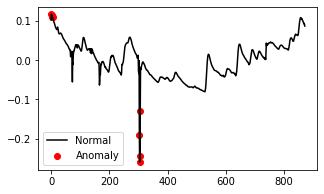

['sub-0016']
['ses-03']
['run-01-cognitive']
['task-cue']


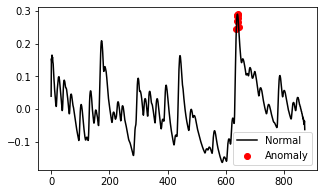

['sub-0016']
['ses-03']
['run-04-vicarious']
['task-cue']


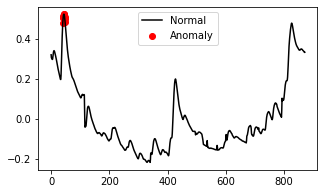

['sub-0016']
['ses-03']
['run-05-cognitive']
['task-cue']


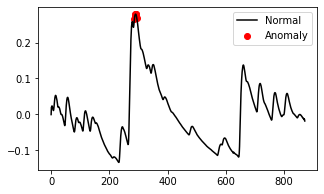

['sub-0016']
['ses-03']
['run-06-pain']
['task-cue']


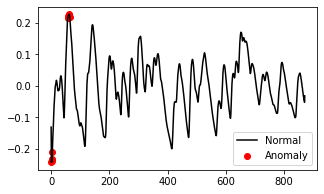

In [17]:
for tsv in sorted(halflist):
    if os.path.exists(tsv):
        filename = os.path.basename(tsv)
        bids_dict = {}
        bids_dict['sub'] = sub  = utils.initialize.extract_bids(filename, 'sub')
        bids_dict['ses'] = ses  = utils.initialize.extract_bids(filename, 'ses')
        bids_dict['run'] = run  = utils.initialize.extract_bids(filename, 'run')
        bids_dict['task']= task = utils.initialize.extract_bids(filename, 'task')

        main_df = pd.read_csv(tsv, sep ='\t')
        filtered_df = filter_physio(main_df)
        from sklearn.preprocessing import StandardScaler
        from sklearn.ensemble import IsolationForest
        outliers_fraction = float(.01)
        scaler = StandardScaler()
        np_scaled = scaler.fit_transform(filtered_df.values.reshape(-1, 1))
        data = pd.DataFrame(np_scaled)
        # train isolation forest
        model =  IsolationForest(contamination=outliers_fraction)
        model.fit(data)
        filtered_df['anomaly'] = model.predict(data)
        # visualization
        fig, ax = plt.subplots(figsize=(5,3))
        a = filtered_df.loc[filtered_df['anomaly'] == -1, ['eda_preproc']] #anomaly
        ax.plot(filtered_df.index, filtered_df['eda_preproc'], color='black', label = 'Normal')
        ax.scatter(a.index,a['eda_preproc'], color='red', label = 'Anomaly')
        plt.legend()
        plt.show();
        plt.close()

# outlier detection 3: facebook prophet

/Users/h/anaconda3/envs/biopac/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


['sub-0015']
['ses-01']
['run-06-vicarious']
['task-cue']


22:19:44 - cmdstanpy - INFO - Chain [1] start processing
22:19:44 - cmdstanpy - INFO - Chain [1] done processing


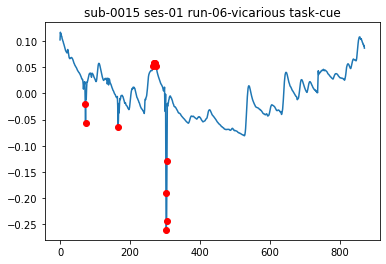

['sub-0016']
['ses-03']
['run-01-cognitive']
['task-cue']


22:20:04 - cmdstanpy - INFO - Chain [1] start processing
22:20:04 - cmdstanpy - INFO - Chain [1] done processing


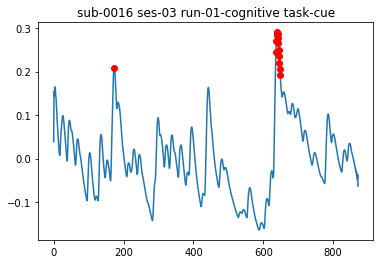

['sub-0016']
['ses-03']
['run-04-vicarious']
['task-cue']


22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing


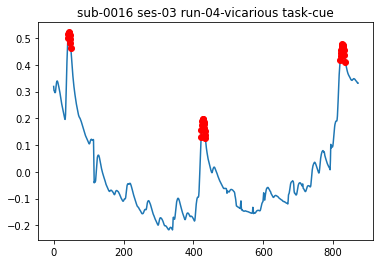

['sub-0016']
['ses-03']
['run-05-cognitive']
['task-cue']


22:20:45 - cmdstanpy - INFO - Chain [1] start processing
22:20:45 - cmdstanpy - INFO - Chain [1] done processing


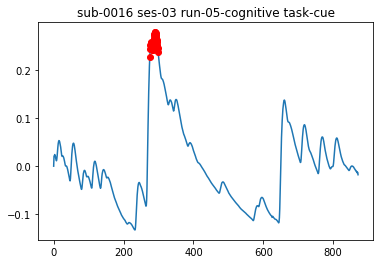

['sub-0016']
['ses-03']
['run-06-pain']
['task-cue']


22:21:06 - cmdstanpy - INFO - Chain [1] start processing
22:21:06 - cmdstanpy - INFO - Chain [1] done processing


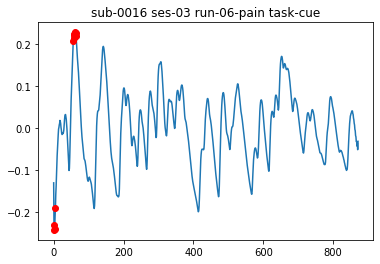

In [7]:
import prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive',
                interval_width = interval_width,
                changepoint_range = changepoint_range, 
                changepoint_prior_scale = 0.05)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] =(forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    return forecasted


for tsv in sorted(halflist):
    if os.path.exists(tsv):
        filename = os.path.basename(tsv)
        bids_dict = {}
        bids_dict['sub'] = sub  = utils.initialize.extract_bids(filename, 'sub')
        bids_dict['ses'] = ses  = utils.initialize.extract_bids(filename, 'ses')
        bids_dict['run'] = run  = utils.initialize.extract_bids(filename, 'run')
        bids_dict['task']= task = utils.initialize.extract_bids(filename, 'task')

        main_df = pd.read_csv(tsv, sep ='\t')
        filtered_df = filter_physio(main_df)

        t = pd.DataFrame()
        t['y'] = filtered_df['eda_preproc']
        t['ds'] = pd.to_datetime(filtered_df.index)

        forecast = fit_predict_model(t, .99, .7)
        forecasted = detect_anomalies(forecast)

        outlier_prophet = forecasted[forecasted['anomaly'] != 0]
        plt.figure(figsize=(5, 3))
        plt.plot(forecasted['fact'])
        plt.plot(outlier_prophet.index.tolist(), outlier_prophet['fact'], 'ro')
        plt.title(f"{sub} {ses} {run} {task}")
        plt.show()
        plt.close()